## Attribution

This section covers more details on attributions using the fitted model object:

1. meaning of the output dataframes
2. what-if scenario generation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from karpiu.models import MMM
from karpiu.explainability import Attributor

pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 50)

In [2]:
%load_ext autoreload
%autoreload 2

### Data and Model

To star with, we need a fitted MMM and we can reuse the one we fitted from the previous `Quickstart` section.

In [3]:
with open("./resource/model.pkl", "rb") as f:
    mmm = pickle.load(f)

After that, users need to specify the interval for the attribution period.

### Attribution on Historic Performance

In [4]:
ATTR_START = "2020-01-01"
ATTR_END = "2020-03-31"

spend_cols = mmm.get_spend_cols()
channels = ["organic"] + spend_cols

In [5]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.05736,0.04121,0.07378,1.00000,0.00000,0.00000,0.10000
1,radio,Positive,0.05506,0.03968,0.06886,1.00000,0.00000,0.00000,0.10000
2,search,Positive,0.20909,0.18660,0.23081,1.00000,0.00000,0.00000,0.10000
3,social,Positive,0.07827,0.05903,0.09767,1.00000,0.00000,0.00000,0.10000
4,tv,Positive,0.10681,0.08683,0.12805,1.00000,0.00000,0.00000,0.10000


 Then users can utilize `Attributor.make_attribution()` to derive attribution summary. There are four output dataframes here:

 1. `activities_attr_df`: attribution against sales date
 2. `spend_attr_df`: attribution against spend date
 3. `spend_df`: spend against spend date (original input)
 4. `cost_df`: cost per sales against spend date (output item 3 divided by output item 2)

 The difference between output item 1 and output item 2 is that item 1 describes attribution against the date the sales actually happened while item 2 is from the accounting prospective -- it describes the attribution against the date when the spend tied to such attribution happened.

 In the case where there is no adstock in the model, one should expect these two output items are identical.

In [6]:
attr_obj = Attributor(mmm, attr_regressors=channels, start=ATTR_START, end=ATTR_END)
activities_attr_df, spend_attr_df, spend_df, cost_df = attr_obj.make_attribution()

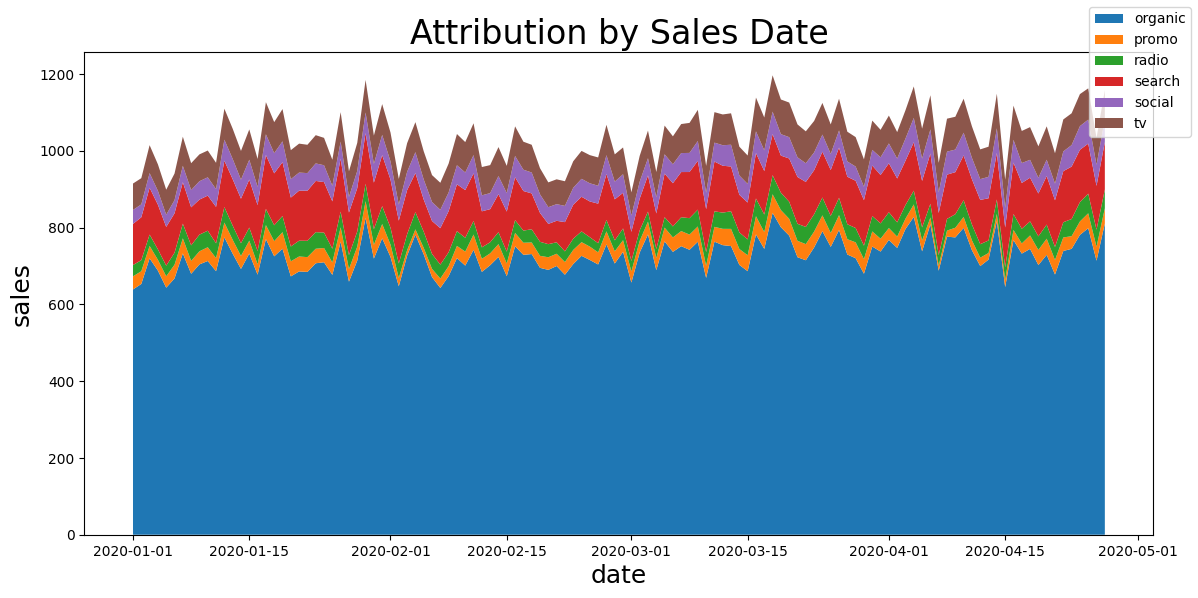

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.stackplot(
    activities_attr_df["date"].values,
    activities_attr_df[channels].values.transpose(),
    labels=channels,
)
ax.set_title("Attribution by Sales Date", fontdict={"fontsize": 24})
ax.set_xlabel("date", fontdict={"fontsize": 18})
ax.set_ylabel("sales", fontdict={"fontsize": 18})
fig.legend()
fig.tight_layout()

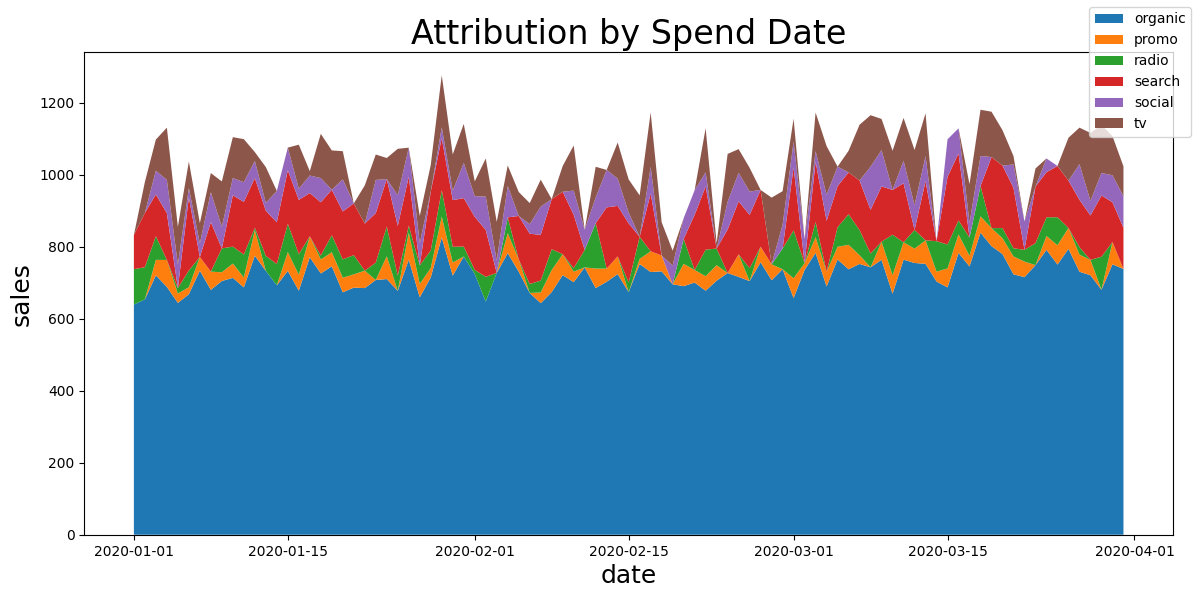

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.stackplot(
    spend_attr_df["date"].values,
    spend_attr_df[channels].values.transpose(),
    labels=channels,
)
ax.set_title("Attribution by Spend Date", fontdict={"fontsize": 24})
ax.set_xlabel("date", fontdict={"fontsize": 18})
ax.set_ylabel("sales", fontdict={"fontsize": 18})
fig.legend()
fig.tight_layout()

### Attribution on Future Performance with Model Prediction

Users can also use attribution on future predictions from the model. This simply means making attribution on predicted response since the actual response has not been observed yet. The first step is to create the data frame contains future information needed to make prediction. The package offers a utilities to make future features by rolling mean.

In [9]:
from karpiu.utils import extend_ts_features

N_PERIODS = 180
df = mmm.get_raw_df()
extended_df = df[["date"] + spend_cols]
extended_df = extend_ts_features(
    extended_df, n_periods=N_PERIODS, date_col="date", rolling_window=30
)
extended_df.tail(10)

,date,promo,radio,search,social,tv
1237,2022-05-22,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1238,2022-05-23,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1239,2022-05-24,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1240,2022-05-25,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1241,2022-05-26,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1242,2022-05-27,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1243,2022-05-28,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1244,2022-05-29,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1245,2022-05-30,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1246,2022-05-31,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000


Then the next step is to make prediction and relabel it as the response column.

In [10]:
pred_df = mmm.predict(extended_df)
expected_sales = np.concatenate(
    [df["sales"].values, pred_df["prediction"].values[-N_PERIODS:]]
)
extended_df["sales"] = expected_sales

With the extended dataframe, users can input it into the Attributor as external data and follow the previous syntax to make attribution.

In [11]:
ATTR_START = "2022-01-01"
ATTR_END = "2022-04-30"

attr_obj = Attributor(mmm, start=ATTR_START, end=ATTR_END, df=extended_df)
activities_attr_df, spend_attr_df, spend_df, cost_df = attr_obj.make_attribution()

In [12]:
spend_attr_df.tail(10)

,date,organic,promo,radio,search,social,tv
110,2022-04-21,1136.12111,61.41783,63.52803,199.37734,85.10207,121.40064
111,2022-04-22,1136.79249,61.45413,63.56557,199.49517,85.15237,121.47240
112,2022-04-23,1137.46429,61.49045,63.60315,199.61307,85.20270,121.54420
113,2022-04-24,1138.13650,61.52679,63.64074,199.73104,85.25305,121.61604
114,2022-04-25,1138.80912,61.56315,63.67836,199.84909,85.30344,121.68793
115,2022-04-26,1139.48215,61.59954,63.71600,199.96721,85.35386,121.75986
116,2022-04-27,1140.15560,61.63594,63.75366,200.08539,85.40431,121.83184
117,2022-04-28,1140.82946,61.67237,63.79134,200.20366,85.45479,121.90386
118,2022-04-29,1141.50373,61.70883,63.82905,200.32199,85.50530,121.97592
119,2022-04-30,1142.17841,61.74530,63.86678,200.44039,85.55584,122.04802
